## Detection model v3 evaluation

In [8]:
import torch
import cv2
from ultralytics import YOLO
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
MODEL_PATH = "runs/detect/yolo_det_v3/weights/best.pt"
model = YOLO(MODEL_PATH)
results = model.val(data="data/dataset_v3/yolo_det_v3.yaml", split="val")

ERROR! Session/line number was not unique in database. History logging moved to new session 284
Ultralytics 8.3.214  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11s summary (fused): 100 layers, 9,453,048 parameters, 0 gradients, 21.5 GFLOPs
val: Fast image access  (ping: 0.30.1 ms, read: 83.752.4 MB/s, size: 86.4 KB)
val: Scanning C:\Users\barte\Desktop\studia\SEM7\INZ\cal-cones\model\data\dataset_v3\val\labels.cache... 3599 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3599/3599  0.0s
val: C:\Users\barte\Desktop\studia\SEM7\INZ\cal-cones\model\data\dataset_v3\val\images\010707.jpg: 3 duplicate labels removed
val: C:\Users\barte\Desktop\studia\SEM7\INZ\cal-cones\model\data\dataset_v3\val\images\014079.jpg: 1 duplicate labels removed
val: C:\Users\barte\Desktop\studia\SEM7\INZ\cal-cones\model\data\dataset_v3\val\images\015634.jpg: 4 duplicate labels removed
val: C:\Users\barte\Desktop\studia\SEM7\INZ\cal-cones\model\data\dataset_v3\val\

In [41]:
print("Eval metrics values:")
# print("Precision:", results.box.p)
# print("Recall:", results.box.r)
print("mAP50:", results.box.map50)
print("mAP75:", results.box.map75)
print("mAP50-95:", results.box.map)
# print("F1 Score:", results.box.f1)


map_50_95_pre_class = results.box.maps.tolist()
df = pd.DataFrame({
    'class' : list(model.names.values()),
    'Precision' : results.box.p,
    'Recall' : results.box.r,
    'mAP50-95' : map_50_95_pre_class,
    'F1 Score' : results.box.f1 
})

Eval metrics values:
mAP50: 0.625440769304707
mAP75: 0.5326207465961648
mAP50-95: 0.48093221256300817


In [42]:
df.head(5)

,class,Precision,Recall,mAP50-95,F1 Score
0,almonds,0.636349,0.543478,0.440844,0.586258
1,apple,0.859905,0.743590,0.716569,0.797529
2,apple-pie,0.839247,0.824480,0.777389,0.831798
3,apricots,0.907542,0.755254,0.763701,0.824425
4,avocado,0.740090,0.537500,0.484213,0.622732


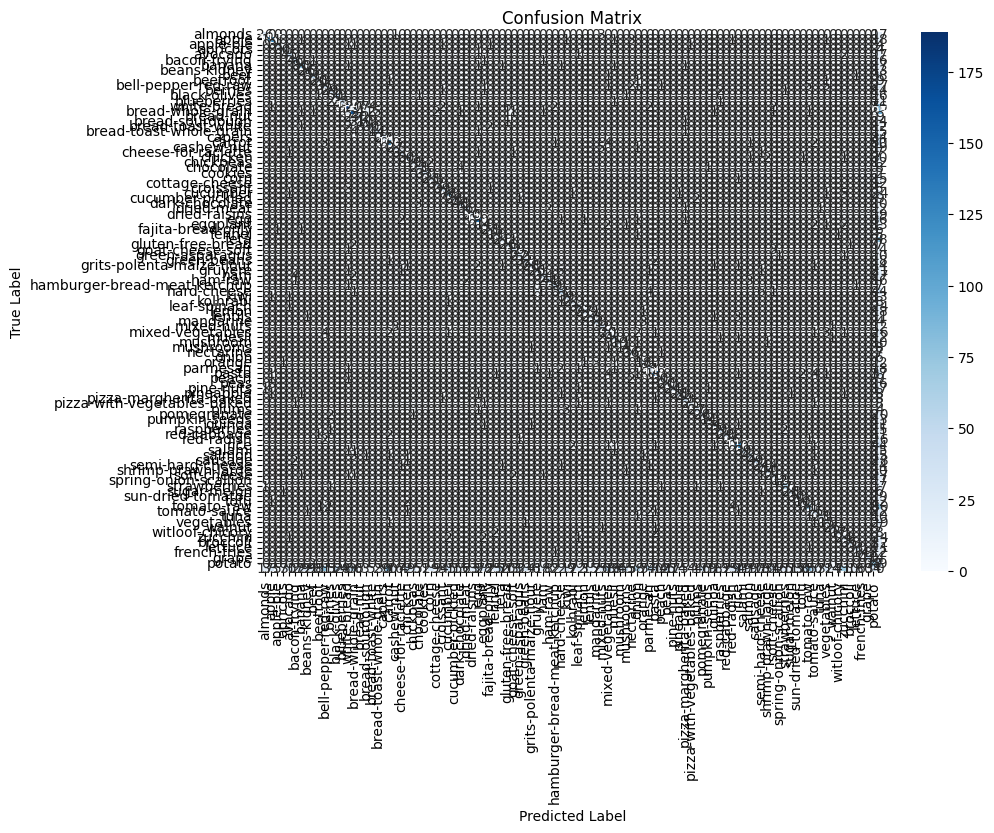

In [67]:
%matplotlib inline
cm = results.confusion_matrix.matrix
names = list(model.names.values())

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=names, yticklabels=names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [77]:
cm = results.confusion_matrix.matrix
class_names = list(model.names.values())
num_classes = cm.shape[0]

# Upewniamy się, że klasy i wymiary się zgadzają
if len(class_names) < num_classes:
    class_names.append("background")
elif len(class_names) > num_classes:
    class_names = class_names[:num_classes]

df_conf = pd.DataFrame(cm, index=class_names, columns=class_names)

mistakes = []
for true_class in class_names:
    if true_class == "background":
        continue  
    total_true = df_conf.loc[true_class].sum()
    if total_true == 0:
        continue
    for pred_class in class_names:
        if pred_class == "background":
            continue  
        if true_class != pred_class:
            count = df_conf.loc[true_class, pred_class]
            if count > 0:
                percentage = (count / total_true) * 100
                mistakes.append((true_class, pred_class, int(count), percentage))

mistakes_sorted = sorted(mistakes, key=lambda x: x[2], reverse=True)

print("Most common model mistakes:")
for i, (true_cls, pred_cls, count, pct) in enumerate(mistakes_sorted[:20], 1):
    print(f"{i}. {true_cls} → {pred_cls}: {count} cases ({pct:.2f}%)")

Most common model mistakes:
1. white-bread → bread-whole-grain: 20 cases (6.39%)
2. bread-whole-grain → white-bread: 13 cases (4.38%)
3. tomato-raw → bell-pepper-red-raw: 12 cases (7.14%)
4. bread-whole-grain → bread-sourdough: 11 cases (3.70%)
5. hard-cheese → gruyere: 11 cases (9.17%)
6. bread-sourdough → white-bread: 8 cases (21.05%)
7. white-bread → bread-sourdough: 7 cases (2.24%)
8. white-bread → gluten-free-bread: 6 cases (1.92%)
9. gruyere → hard-cheese: 6 cases (10.34%)
10. hard-cheese → semi-hard-cheese: 6 cases (5.00%)
11. pizza-with-vegetables-baked → pizza-margherita-baked: 6 cases (13.64%)
12. bell-pepper-red-raw → tomato-raw: 5 cases (6.41%)
13. bell-pepper-red-raw → vegetables: 5 cases (6.41%)
14. bread-whole-grain → bread-toast-whole-grain: 5 cases (1.68%)
15. cashew-nut → mixed-nuts: 5 cases (9.62%)
16. cucumber → zucchini: 5 cases (4.50%)
17. white-bread → bread-toast-white: 4 cases (1.28%)
18. bread-whole-grain → bread-nut: 4 cases (1.35%)
19. bread-nut → bread-whol